# Import libraries & Data

In [1]:
# Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import missingno as msno

from sklearn.impute import KNNImputer

In [2]:
# importing the datasets
all_datasets_paths=glob.glob("..\\4. Data Analysis - Stock Market Analysis\\datasets\\*")
stock_to_analyse  = "TCS"

df = None
dataframes = []

for path in all_datasets_paths:
    dataframes.append(pd.read_csv(path))
    
    if stock_to_analyse in path:
        df = pd.read_csv(path)
        
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2004-08-25,TCS,EQ,850.00,1198.7,1198.7,979.00,985.00,987.95,1008.32,17116372,1.725876e+15,NaN,5206360,0.3042
1,2004-08-26,TCS,EQ,987.95,992.0,997.0,975.30,976.85,979.00,985.65,5055400,4.982865e+14,NaN,1294899,0.2561
2,2004-08-27,TCS,EQ,979.00,982.4,982.4,958.55,961.20,962.65,969.94,3830750,3.715586e+14,NaN,976527,0.2549
3,2004-08-30,TCS,EQ,962.65,969.9,990.0,965.00,986.40,986.75,982.65,3058151,3.005106e+14,NaN,701664,0.2294
4,2004-08-31,TCS,EQ,986.75,986.5,990.0,976.00,987.80,988.10,982.18,2649332,2.602133e+14,NaN,695234,0.2624


In [3]:
# Combining all the data sets
master_data = pd.concat(dataframes, sort=False)
master_data.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,Company Name,Industry,ISIN Code
0,2007-11-27,MUNDRAPORT,EQ,440.00,770.00,1050.00,770.0,959.0,962.90,984.72,27294366.0,2.687719e+15,NaN,9859619.0,0.3612,NaN,NaN,NaN
1,2007-11-28,MUNDRAPORT,EQ,962.90,984.00,990.00,874.0,885.0,893.90,941.38,4581338.0,4.312765e+14,NaN,1453278.0,0.3172,NaN,NaN,NaN
2,2007-11-29,MUNDRAPORT,EQ,893.90,909.00,914.75,841.0,887.0,884.20,888.09,5124121.0,4.550658e+14,NaN,1069678.0,0.2088,NaN,NaN,NaN
3,2007-11-30,MUNDRAPORT,EQ,884.20,890.00,958.00,890.0,929.0,921.55,929.17,4609762.0,4.283257e+14,NaN,1260913.0,0.2735,NaN,NaN,NaN
4,2007-12-03,MUNDRAPORT,EQ,921.55,939.75,995.00,922.0,980.0,969.30,965.65,2977470.0,2.875200e+14,NaN,816123.0,0.2741,NaN,NaN,NaN


# Missing Value Handling

In [4]:
class missing_values_handler():
    
    def __init__(self, df):
        self.df = df
        self.nulls_in_row_df = None
        self.deleted_rows_df = None
        
        self.null_in_col_df = None
        self.deleted_cols_df = None
        
    def find_columnwise_na(self):
        """
        Find out the columns and respective null value ounts and its percentage with respect to total number of records.
        """
        # creating the data frame with column name and respective null count
        null_in_col_df = self.df.isnull().sum()
        null_in_col_df = pd.DataFrame({"Columns Name":null_in_col_df.index, "Number of NA in Column":list(null_in_col_df)})
        null_in_col_df["Percentage"] = round(null_in_col_df["Number of NA in Column"]*100/len(self.df), 2)
        
        # sorting the data frame
        null_in_col_df = null_in_col_df.sort_values("Number of NA in Column", ascending=False)
        
        # saving the data
        self.null_in_col_df = null_in_col_df
        return null_in_col_df
    
    
    def delete_cols_above_threashold_na(self, threashold, inplace):
        """
        Find the columns in dataframe with na count higher than threashold and delete them
        """
        # create dataframe with cols and na count
        self.find_columnwise_na()
        
        # find the columns having higher count than threashold
        cols = list(self.null_in_col_df[self.null_in_col_df["Percentage"]>threashold]["Columns Name"])
        
        # delete the columns
        deleted_cols_df = self.df.drop(cols, axis=1)
        
        # saving data
        self.deleted_cols_df = deleted_cols_df
        if inplace:
            self.df = deleted_cols_df
            
        return deleted_cols_df
        
    # Lets findout the rows having maximum number of columns with NA value
    def find_rowwise_na(self):
        """
        Find out the number of columns having NA values for a rows, so that rows having more number of NA valued columns can be deleted.
        """

        df_isnull = self.df.isnull()
        nulls_in_row_dict = {}

        # calculate the number of columns having null value
        for index, row in df_isnull.iterrows():
            nulls_in_row_dict[index] = sum(row)

        # form a dataframe
        nulls_in_row_df = pd.DataFrame({"Row number": nulls_in_row_dict.keys(), 
                                        "Number of columns having NA": nulls_in_row_dict.values()}, index=None)

        # find percentage of columns having 0 value for given rows and sort
        nulls_in_row_df["Percentage"] =  round(nulls_in_row_df["Number of columns having NA"]/len(df_isnull.columns), 2)*100
        nulls_in_row_df = nulls_in_row_df.sort_values("Number of columns having NA", ascending=False)
        
        self.nulls_in_row_df = nulls_in_row_df
        return nulls_in_row_df
    
    
    
    # delete the rows based on the given number of threashold percentage, row will be deleted for which number of columns having missing values is higher than given threashold value 
    def delete_rows_above_threashold_na(self, threashold, inplace):
        """
        Delete the rows having more number of NA values than specified threashold
        """
        # find rows above threashold number of na
        rows_numbers = self.nulls_in_row_df[self.nulls_in_row_df["Percentage"]>threashold]["Row number"]
        rows_numbers = list(rows_numbers)
        
        # delete the rows
        deleted_rows_df = self.df.drop(index=rows_numbers)
        
        # save changes
        self.deleted_rows_df = deleted_rows_df
        
        if inplace:
            self.df = deleted_rows_df
            
        return deleted_rows_df
    
    
    
    
missing_handler = missing_values_handler(master_data)

In [5]:
master_data.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,Company Name,Industry,ISIN Code
0,2007-11-27,MUNDRAPORT,EQ,440.00,770.00,1050.00,770.0,959.0,962.90,984.72,27294366.0,2.687719e+15,NaN,9859619.0,0.3612,NaN,NaN,NaN
1,2007-11-28,MUNDRAPORT,EQ,962.90,984.00,990.00,874.0,885.0,893.90,941.38,4581338.0,4.312765e+14,NaN,1453278.0,0.3172,NaN,NaN,NaN
2,2007-11-29,MUNDRAPORT,EQ,893.90,909.00,914.75,841.0,887.0,884.20,888.09,5124121.0,4.550658e+14,NaN,1069678.0,0.2088,NaN,NaN,NaN
3,2007-11-30,MUNDRAPORT,EQ,884.20,890.00,958.00,890.0,929.0,921.55,929.17,4609762.0,4.283257e+14,NaN,1260913.0,0.2735,NaN,NaN,NaN
4,2007-12-03,MUNDRAPORT,EQ,921.55,939.75,995.00,922.0,980.0,969.30,965.65,2977470.0,2.875200e+14,NaN,816123.0,0.2741,NaN,NaN,NaN


<Axes: >

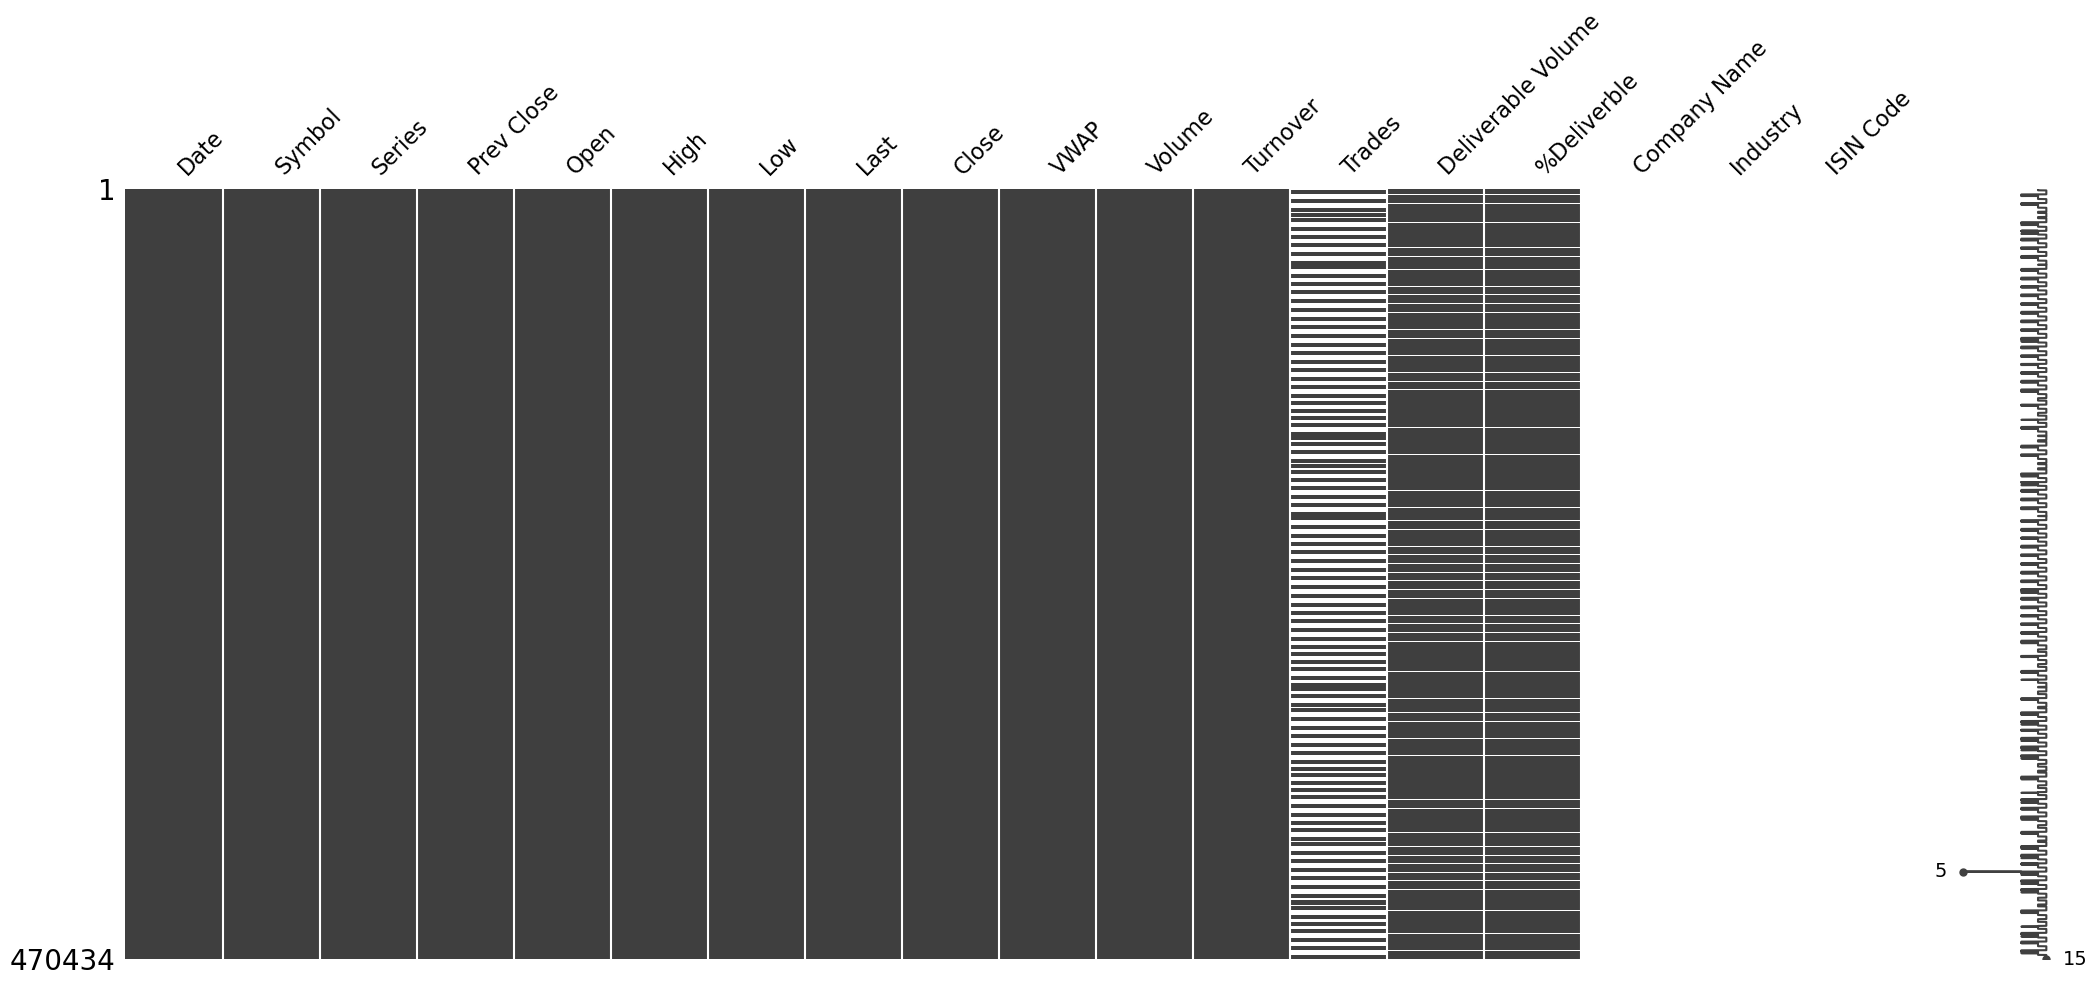

In [6]:
# plotting the matrix showing the null values of columns
msno.matrix(master_data)

<Axes: >

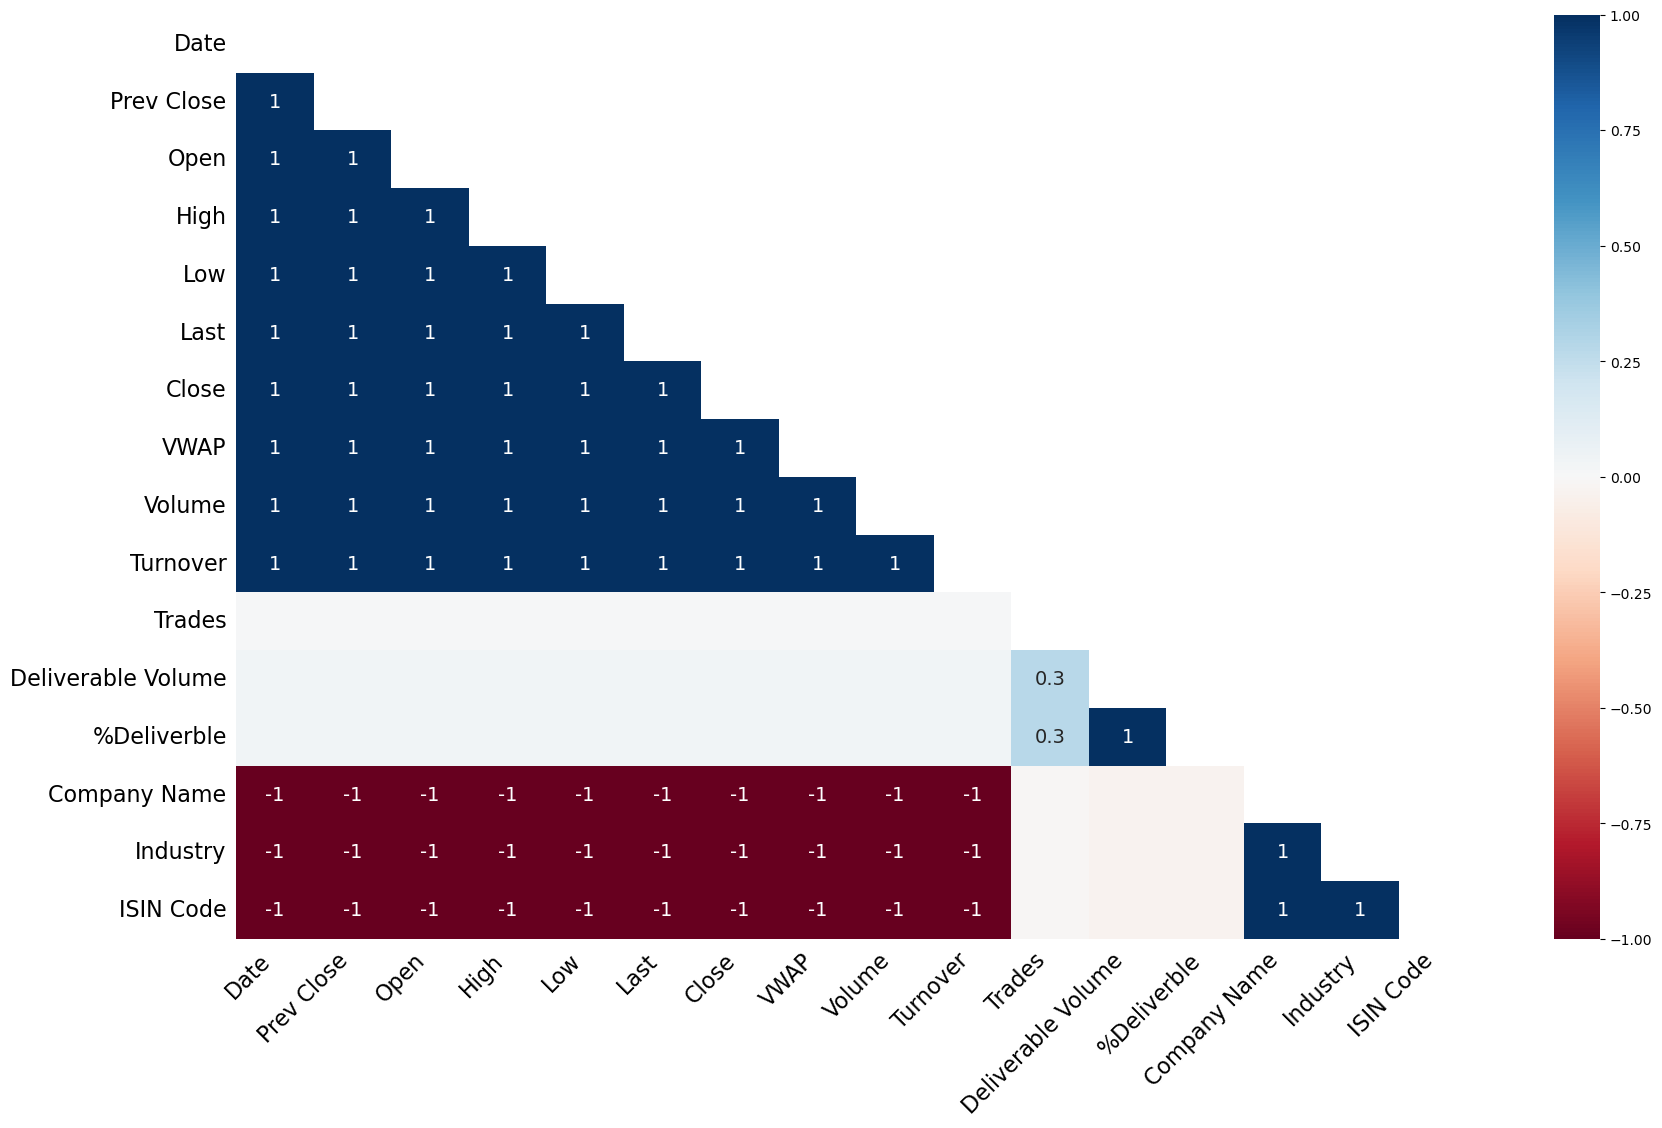

In [7]:
# plotting the heatmap showing correlation of columns
msno.heatmap(master_data)

<Axes: >

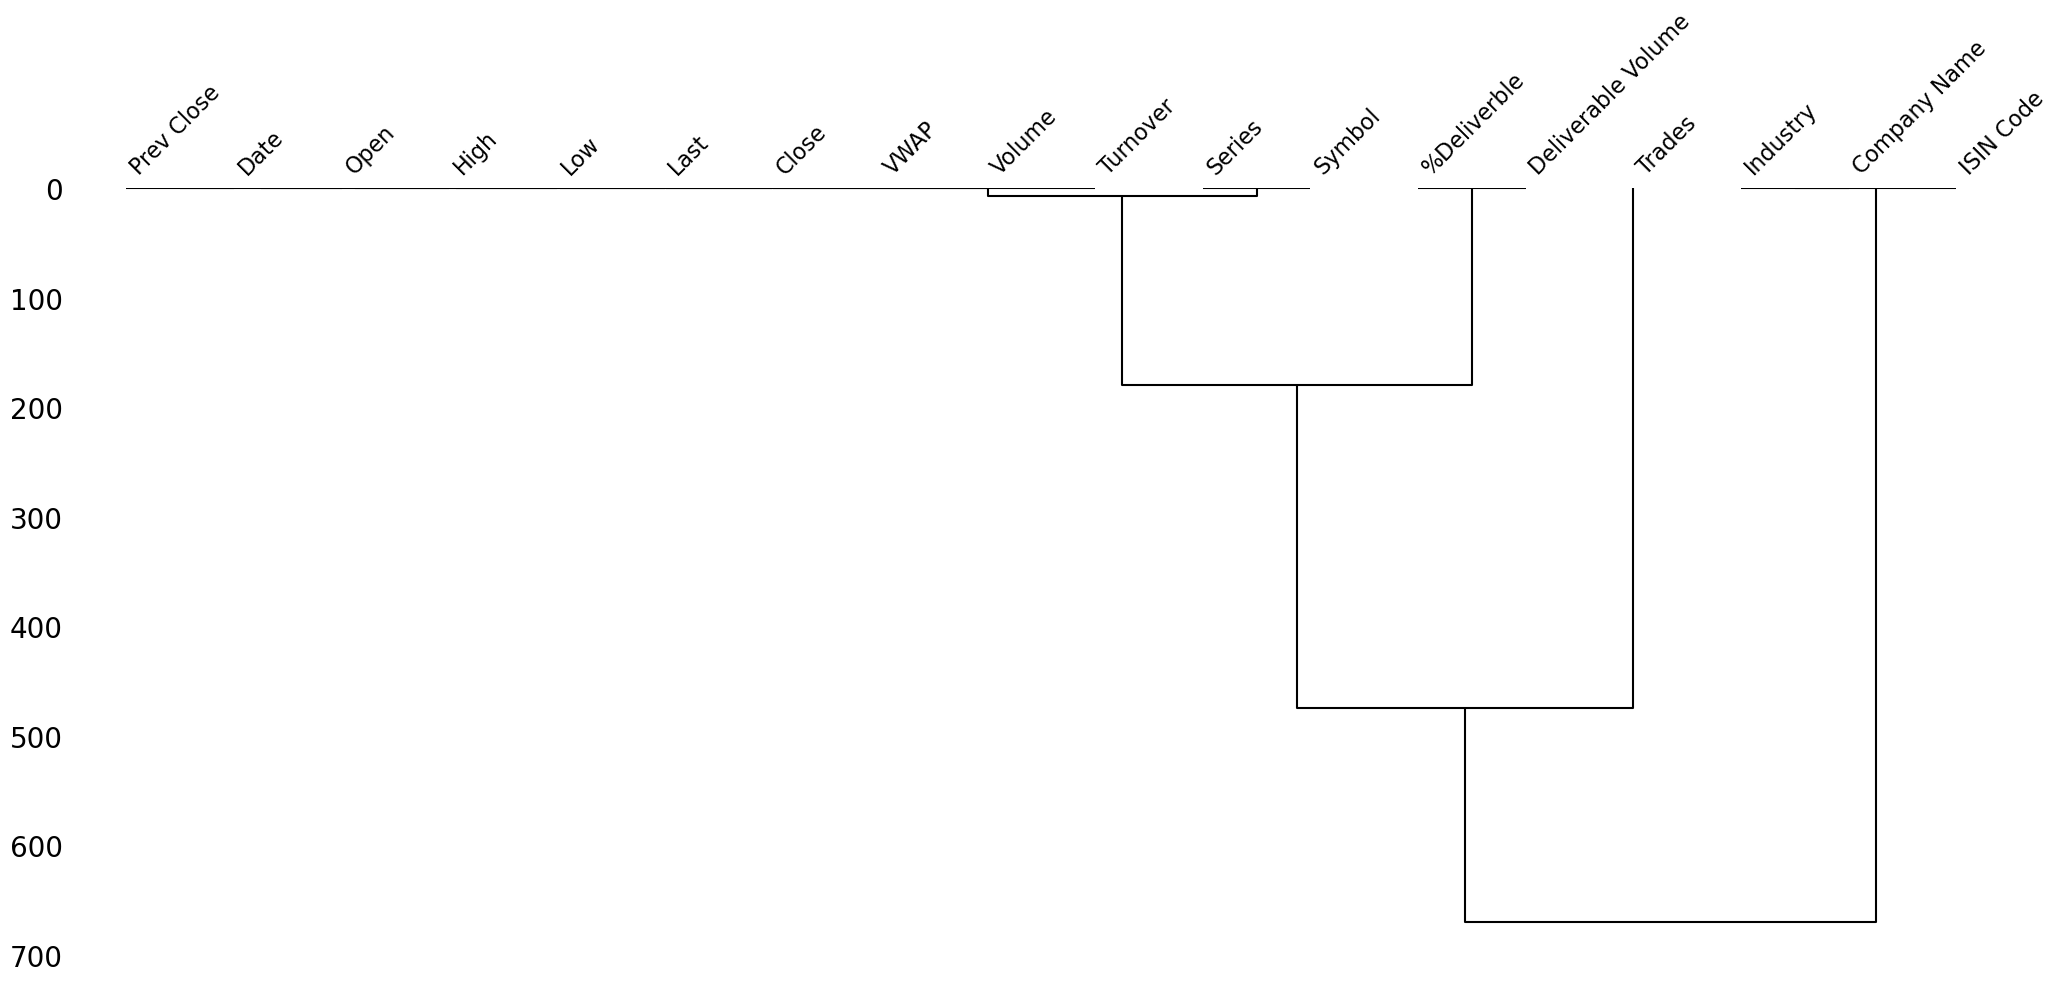

In [8]:
# plotting the dendrograph showing the tree based relationship of null values in column
msno.dendrogram(master_data)

In [9]:
# Find out the percentage of null values in each columns
missing_handler.find_columnwise_na()

,Columns Name,Number of NA in Column,Percentage
17,ISIN Code,470384,99.99
16,Industry,470384,99.99
15,Company Name,470384,99.99
12,Trades,229746,48.84
14,%Deliverble,32204,6.85
13,Deliverable Volume,32204,6.85
10,Volume,50,0.01
11,Turnover,50,0.01
0,Date,50,0.01
8,Close,50,0.01


### 1. Handling the Null values in industry columns

In [10]:
# Find out the existing values in Industry column
master_data["Industry"].unique()

array([nan, 'SERVICES', 'CONSUMER GOODS', 'FINANCIAL SERVICES',
       'AUTOMOBILE', 'TELECOM', 'ENERGY', 'PHARMA', 'METALS',
       'CEMENT & CEMENT PRODUCTS', 'IT', 'CONSTRUCTION',
       'FERTILISERS & PESTICIDES', 'MEDIA & ENTERTAINMENT'], dtype=object)

In [11]:
# Symbol columns where Industry column is Null, to find out which company is not having data for industry column
master_data[master_data["Industry"].isnull()]["Symbol"].unique()

array(['MUNDRAPORT', 'ADANIPORTS', 'ASIANPAINT', 'UTIBANK', 'AXISBANK',
       'BAJAJ-AUTO', 'BAJAJFINSV', 'BAJAUTOFIN', 'BAJFINANCE', 'BHARTI',
       'BHARTIARTL', 'BPCL', 'BRITANNIA', 'CIPLA', 'COALINDIA', 'DRREDDY',
       'EICHERMOT', 'GAIL', 'GRASIM', 'HCLTECH', 'HDFC', 'HDFCBANK',
       'HEROHONDA', 'HEROMOTOCO', 'HINDALC0', 'HINDALCO', 'HINDLEVER',
       'HINDUNILVR', 'ICICIBANK', 'INDUSINDBK', 'INFOSYSTCH', 'INFY',
       'IOC', 'ITC', 'JSWSTL', 'JSWSTEEL', 'KOTAKMAH', 'KOTAKBANK', 'LT',
       'MARUTI', 'M&M', 'NESTLEIND', 'NTPC', 'ONGC', 'POWERGRID',
       'RELIANCE', 'SBIN', 'SHREECEM', 'SUNPHARMA', 'TELCO', 'TATAMOTORS',
       'TISCO', 'TATASTEEL', 'TCS', 'TECHM', 'TITAN', 'ULTRACEMCO',
       'UNIPHOS', 'UPL', 'SESAGOA', 'SSLT', 'VEDL', 'WIPRO', 'ZEETELE',
       'ZEEL'], dtype=object)

In [12]:
# Replacing the Industry columns null values with the correct values based on the existing information in Industry column
# For Ports
master_data.loc[master_data["Symbol"]=="MUNDRAPORT", "Industry"] = "PORTS"
master_data.loc[master_data["Symbol"]=="ADANIPORTS", "Industry"] = "PORTS"

# For Financial Services
master_data.loc[master_data["Symbol"]=="UTIBANK", "Industry"] = "FINANCIAL SERVICES"
master_data.loc[master_data["Symbol"]=="AXISBANK", "Industry"] = "FINANCIAL SERVICES"
master_data.loc[master_data["Symbol"]=="BAJAJFINSV", "Industry"] = "FINANCIAL SERVICES"
master_data.loc[master_data["Symbol"]=="BAJAUTOFIN", "Industry"] = "FINANCIAL SERVICES"
master_data.loc[master_data["Symbol"]=="BAJFINANCE", "Industry"] = "FINANCIAL SERVICES"
master_data.loc[master_data["Symbol"]=="KOTAKBANK", "Industry"] = "FINANCIAL SERVICES"
master_data.loc[master_data["Symbol"]=="KOTAKMAH", "Industry"] = "FINANCIAL SERVICES"
master_data.loc[master_data["Symbol"]=="INDUSINDBK", "Industry"] = "FINANCIAL SERVICES"
master_data.loc[master_data["Symbol"]=="ICICIBANK", "Industry"] = "FINANCIAL SERVICES"
master_data.loc[master_data["Symbol"]=="HDFCBANK", "Industry"] = "FINANCIAL SERVICES"
master_data.loc[master_data["Symbol"]=="HDFC", "Industry"] = "FINANCIAL SERVICES"
master_data.loc[master_data['Symbol']=='SBIN', 'Industry'] = 'FINANCIAL SERVICES'

#ForTelecom
master_data.loc[master_data["Symbol"]=='BHARTIARTL', "Industry"] = 'TELECOM'
master_data.loc[master_data["Symbol"]=='BHARTI', "Industry"] = 'TELECOM'

# For Consumer Goods
master_data.loc[master_data["Symbol"]=="BRITANNIA", "Industry"] = 'CONSUMER GOODS'
master_data.loc[master_data["Symbol"]=="HINDUNILVR", "Industry"] = 'CONSUMER GOODS'
master_data.loc[master_data["Symbol"]=="ITC", "Industry"] = 'CONSUMER GOODS'
master_data.loc[master_data['Symbol']=='HINDLEVER', 'Industry'] = 'CONSUMER GOODS'
master_data.loc[master_data['Symbol']=='NESTLEIND', 'Industry'] = 'CONSUMER GOODS'
master_data.loc[master_data['Symbol']=='SSLT', 'Industry'] = 'CONSUMER GOODS'

# For Automobile
master_data.loc[master_data["Symbol"]=="BAJAJ-AUTO", "Industry"] = 'AUTOMOBILE'
master_data.loc[master_data["Symbol"]=="EICHERMOT", "Industry"] = 'AUTOMOBILE'
master_data.loc[master_data["Symbol"]=="HEROHONDA", "Industry"] = 'AUTOMOBILE'
master_data.loc[master_data["Symbol"]=="HEROMOTOCO", "Industry"] = 'AUTOMOBILE'
master_data.loc[master_data["Symbol"]=="M&M", "Industry"] = 'AUTOMOBILE'
master_data.loc[master_data["Symbol"]=="MARUTI", "Industry"] = 'AUTOMOBILE'
master_data.loc[master_data["Symbol"]=="TATAMOTORS", "Industry"] = 'AUTOMOBILE'
master_data.loc[master_data["Symbol"]=="TELCO", "Industry"] = 'AUTOMOBILE'

# For IT
master_data.loc[master_data['Symbol']=='WIPRO', 'Industry'] = 'IT'
master_data.loc[master_data['Symbol']=='INFOSYSTCH', 'Industry'] = 'IT'
master_data.loc[master_data['Symbol']=='HCLTECH', 'Industry'] = 'IT'
master_data.loc[master_data['Symbol']=='INFY', 'Industry'] = 'IT'
master_data.loc[master_data['Symbol']=='TCS', 'Industry'] = 'IT'
master_data.loc[master_data['Symbol']=='TECHM', 'Industry'] = 'IT'

# For Media & Entertainment
master_data.loc[master_data['Symbol']=='ZEETELE', 'Industry'] = 'MEDIA & ENTERTAINMENT'
master_data.loc[master_data['Symbol']=='ZEEL', 'Industry'] = 'MEDIA & ENTERTAINMENT'

# For Fertilisers & Pesticides
master_data.loc[master_data['Symbol']=='SHREECEM', 'Industry'] = 'FERTILISERS & PESTICIDES'
master_data.loc[master_data['Symbol']=='UPL', 'Industry'] = 'FERTILISERS & PESTICIDES'

# For Construction
master_data.loc[master_data['Symbol']=='LT', 'Industry'] = 'CONSTRUCTION'
master_data.loc[master_data['Symbol']=='ULTRACEMCO', 'Industry'] = 'CEMENT & CEMENT PRODUCTS'

# For Energy
master_data.loc[master_data['Symbol']=='POWERGRID', 'Industry'] = 'ENERGY'
master_data.loc[master_data['Symbol']=='RELIANCE', 'Industry'] = 'ENERGY'
master_data.loc[master_data['Symbol']=='BPCL', 'Industry'] = 'ENERGY'
master_data.loc[master_data['Symbol']=='COALINDIA', 'Industry'] = 'ENERGY'
master_data.loc[master_data['Symbol']=='GAIL', 'Industry'] = 'ENERGY'
master_data.loc[master_data['Symbol']=='ONGC', 'Industry'] = 'ENERGY'
master_data.loc[master_data['Symbol']=='IOC', 'Industry'] = 'ENERGY'
master_data.loc[master_data['Symbol']=='NTPC', 'Industry'] = 'ENERGY'

# For Metals
master_data.loc[master_data['Symbol']=='SESAGOA', 'Industry'] = 'METALS'
master_data.loc[master_data['Symbol']=='HINDALC0', 'Industry'] = 'METALS'
master_data.loc[master_data['Symbol']=='HINDALCO', 'Industry'] = 'METALS'
master_data.loc[master_data['Symbol']=='JSWSTL', 'Industry'] = 'METALS'
master_data.loc[master_data['Symbol']=='JSWSTEEL', 'Industry'] = 'METALS'
master_data.loc[master_data['Symbol']=='TATASTEEL', 'Industry'] = 'METALS'
master_data.loc[master_data['Symbol']=='GRASIM', 'Industry'] = 'METALS'
master_data.loc[master_data['Symbol']=='TISCO', 'Industry'] = 'METALS'
master_data.loc[master_data['Symbol']=='VEDL', 'Industry'] = 'METALS'

# For Pharma
master_data.loc[master_data['Symbol']=='SUNPHARMA', 'Industry'] = 'PHARMA'
master_data.loc[master_data['Symbol']=='CIPLA', 'Industry'] = 'PHARMA'
master_data.loc[master_data['Symbol']=='DRREDDY', 'Industry'] = 'PHARMA'

# For Paints
master_data.loc[master_data['Symbol']=='ASIANPAINT', 'Industry'] = "PAINTS"

# ForJewelry
master_data.loc[master_data['Symbol']=='TITAN', 'Industry'] = 'JEWELRY'
master_data.loc[master_data['Symbol']=='UNIPHOS', 'Industry'] = 'CHEMICAL'

In [13]:
# Symbol columns where Industry column is Null, to find out which company is not having data for industry column
master_data[master_data["Industry"].isnull()]["Symbol"].unique()

array([], dtype=object)

In [14]:
# Find out the existing values in Industry column
master_data["Industry"].unique()

array(['PORTS', 'PAINTS', 'FINANCIAL SERVICES', 'AUTOMOBILE', 'TELECOM',
       'ENERGY', 'CONSUMER GOODS', 'PHARMA', 'METALS', 'IT',
       'CONSTRUCTION', 'FERTILISERS & PESTICIDES', 'JEWELRY',
       'CEMENT & CEMENT PRODUCTS', 'CHEMICAL', 'MEDIA & ENTERTAINMENT'],
      dtype=object)

#### Null values in Industry column is removed and replaced with the correct values

#### We will delete the ISIN Code, Company name and trade columns as it is having 99.99% and 48.84% Null values

In [15]:
# Delete the columns having the more than 40% null values
master_data = missing_handler.delete_cols_above_threashold_na(40, False)

# Find out the percentage of null values in each columns
missing_handler = missing_values_handler(master_data)
missing_handler.find_columnwise_na()

,Columns Name,Number of NA in Column,Percentage
12,Deliverable Volume,32204,6.85
13,%Deliverble,32204,6.85
0,Date,50,0.01
3,Prev Close,50,0.01
4,Open,50,0.01
5,High,50,0.01
6,Low,50,0.01
7,Last,50,0.01
8,Close,50,0.01
9,VWAP,50,0.01


In [16]:
# To impute the missing values in the data with the help of KNN imputation method

def knn_impute_null(df):
    
    # find out the numerical columns and non numerical columns to impute the data only in numerical one
    numerical_float_colummns = df.select_dtypes(include=[np.number, 'float']).columns.to_list()
    non_numerical_float_colummns = df.select_dtypes(exclude=[np.number, 'float']).columns.to_list()

    print(numerical_float_colummns)
    print(non_numerical_float_colummns)
    
    # get the data for the numerical columns only
    selected_data = df[numerical_float_colummns]

    # create instance of KNN imputer
    knn_imputer = KNNImputer(n_neighbors=5)
    imputed_data = knn_imputer.fit_transform(selected_data)
    imputed_df = pd.DataFrame(imputed_data, columns = numerical_float_colummns)

    # add non numerical columns to impted data
    for col in imputed_df.columns:
        print(col)
        df[col] = imputed_df[col]
        
    return imputed_df[list(master_data.columns)]

In [19]:
master_data = master_data.dropna()

In [115]:
# Missing value imputed data
master_data_imputed = knn_impute_null(master_data)
master_data_imputed

['Prev Close', 'Open', 'High', 'Low', 'Last', 'Close', 'VWAP', 'Volume', 'Turnover', 'Deliverable Volume', '%Deliverble']
['Date', 'Symbol', 'Series', 'Industry']
Prev Close
Open
High
Low
Last
Close
VWAP
Volume
Turnover
Deliverable Volume
%Deliverble


KeyError: "['Date', 'Symbol', 'Series', 'Industry'] not in index"

In [22]:
master_data.to_csv("national_stock_exchange_2004_2022.csv")